Project 3 - Buffalo 311 Forecast

In [1]:
import requests
import pandas as pd
import numpy as np
from prophet import Prophet
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.pyplot as plt
%matplotlib inline
 
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')


In [2]:
# Fetch the dataset
url = "https://data.buffalony.gov/resource/whkc-e5vr.json?"   # $limit=50000
response = requests.get(url)
data = response.json()

In [3]:
# Convert to a DataFrame and preprocess
df = pd.DataFrame(data)
df = df[['open_date', 'type', 'latitude', 'longitude', 'reason']]
df['open_date'] = pd.to_datetime(df['open_date'])

In [4]:
df.head()

,open_date,type,latitude,longitude,reason
0,2023-03-09 09:49:00,Paving (Req_Serv),42.856463120634494,-78.83034407693124,Engineering - Street Repairs
1,2023-02-07 15:04:00,Totes Replace (Req_Serv),42.89583412887019,-78.8247421339197,Sanitation
2,2023-03-09 11:11:00,QRT Other Issue (Req_Serv),42.91232235456432,-78.83024971030892,Citizen Services - Quick Response Teams
3,2023-03-12 16:35:00,Housing Violations (Req_Serv),42.94492544877188,-78.81613193511131,Housing
4,2023-04-28 08:43:00,Parking Issues (Req_Serv),42.89950364149294,-78.86091335961936,Parking Violations Bureau


In [5]:
# Filter data by 12-31-2022
df = df[df['open_date'] < '2023-01-01']

In [6]:
df['open_date'] = pd.to_datetime(df['open_date']).dt.date

<ipython-input-6-f55888bb8d19>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['open_date'] = pd.to_datetime(df['open_date']).dt.date


In [7]:
df.tail()

,open_date,type,latitude,longitude,reason
961,2022-12-30,Pot Hole (Req_Serv),42.94055650660653,-78.8916916843101,Engineering - Street Repairs
962,2022-12-19,Recycling Tote Replace (Req_Serv),42.868644240936305,-78.86382293613005,Sanitation
967,2022-12-08,BMHA Issue (Req_Serv),42.8884629040955,-78.81477830552016,BMHA
975,2022-11-01,Housing Violations (Req_Serv),42.87841880505128,-78.83586331982998,Housing
995,2022-03-01,Sign Maintenance (Req_Serv),42.959594127371545,-78.9040850774475,Engineering - Traffic


In [8]:
# Count the number of requests per day
daily_requests = df.groupby('open_date').size().reset_index(name='count')

In [9]:
daily_requests.tail()

,open_date,count
64,2022-12-27,5
65,2022-12-28,21
66,2022-12-29,7
67,2022-12-30,13
68,2022-12-31,3


In [10]:
from datetime import date
import holidays
  
# Select country
us_holidays = holidays.UnitedStates(years = [2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])

holidays = pd.DataFrame({
  'holiday': us_holidays.values(),
  'ds': us_holidays.keys(),
  'lower_window': 0,
  'upper_window': 0,
}) 
#holidays

In [11]:
holidays

,holiday,ds,lower_window,upper_window
0,New Year's Day,2016-01-01,0,0
1,Martin Luther King Jr. Day,2016-01-18,0,0
2,Washington's Birthday,2016-02-15,0,0
3,Memorial Day,2016-05-30,0,0
4,Independence Day,2016-07-04,0,0
...,...,...,...,...
179,Labor Day,2015-09-07,0,0
180,Columbus Day,2015-10-12,0,0
181,Veterans Day,2015-11-11,0,0
182,Thanksgiving,2015-11-26,0,0


In [12]:
# Prepare for Prophet

In [13]:
daily_requests_df = daily_requests.rename(columns={'open_date':'ds', 'count':'y'})
daily_requests_df.head()

,ds,y
0,2020-06-26,1
1,2020-08-20,1
2,2020-09-16,1
3,2021-02-09,1
4,2021-02-23,1


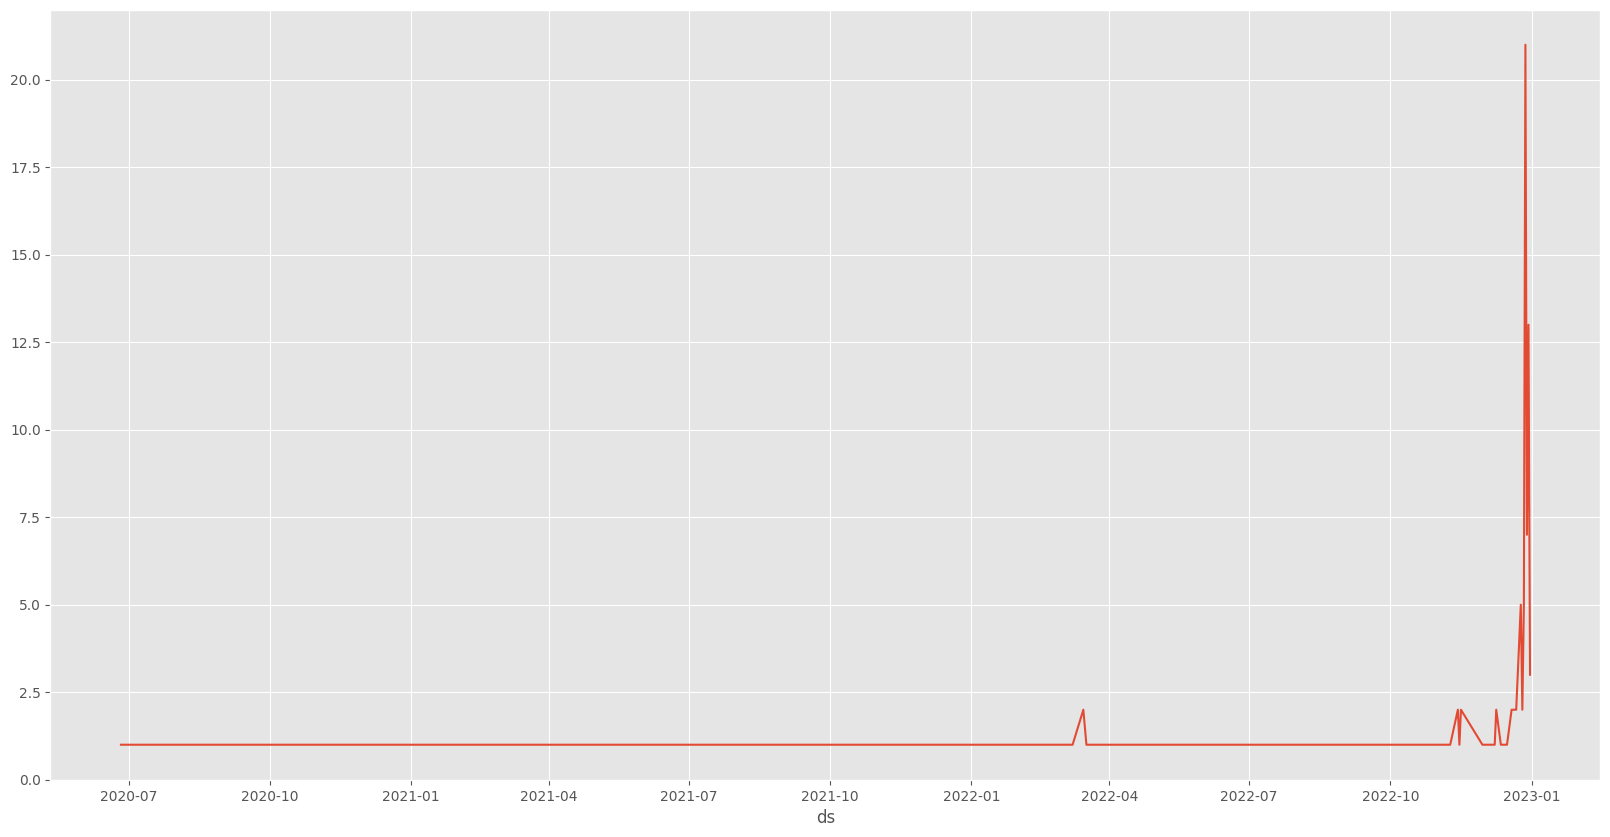

In [14]:
daily_requests_df.set_index('ds').y.plot();

In [15]:
# Running Prophet

In [16]:
# Instantiate Model
model = Prophet(holidays = holidays)

# Fit Model
model.fit(daily_requests_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgwbaww_f/pu3rylu4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgwbaww_f/1ltefgtz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67352', 'data', 'file=/tmp/tmpgwbaww_f/pu3rylu4.json', 'init=/tmp/tmpgwbaww_f/1ltefgtz.json', 'output', 'file=/tmp/tmpgwbaww_f/prophet_model8rri8pmw/prophet_model-20230511035226.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:52:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:52:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [17]:
# Creat future data frame
future = model.make_future_dataframe(periods=365, freq = 'D')
future.tail()

,ds
429,2023-12-27
430,2023-12-28
431,2023-12-29
432,2023-12-30
433,2023-12-31


In [18]:
# Add predictions to the forecast dataframe
forecast = model.predict(future)

In [19]:
forecast.tail().T

,429,430,431,432,433
ds,2023-12-27 00:00:00,2023-12-28 00:00:00,2023-12-29 00:00:00,2023-12-30 00:00:00,2023-12-31 00:00:00
trend,0.541614,0.542221,0.542828,0.543435,0.544041
yhat_lower,8.874884,7.180608,8.938933,0.28087,10.790678
yhat_upper,12.832675,11.127703,12.799054,4.080291,14.393256
trend_lower,0.541614,0.542221,0.542828,0.543434,0.544041
...,...,...,...,...,...
yearly_upper,7.314715,8.248612,9.16025,10.033426,10.852094
multiplicative_terms,0.0,0.0,0.0,0.0,0.0
multiplicative_terms_lower,0.0,0.0,0.0,0.0,0.0
multiplicative_terms_upper,0.0,0.0,0.0,0.0,0.0


In [20]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
429,2023-12-27,10.927744,8.874884,12.832675
430,2023-12-28,9.107484,7.180608,11.127703
431,2023-12-29,10.805170,8.938933,12.799054
432,2023-12-30,2.184499,0.280870,4.080291
433,2023-12-31,12.606936,10.790678,14.393256


In [21]:
# Plotting Prophet results

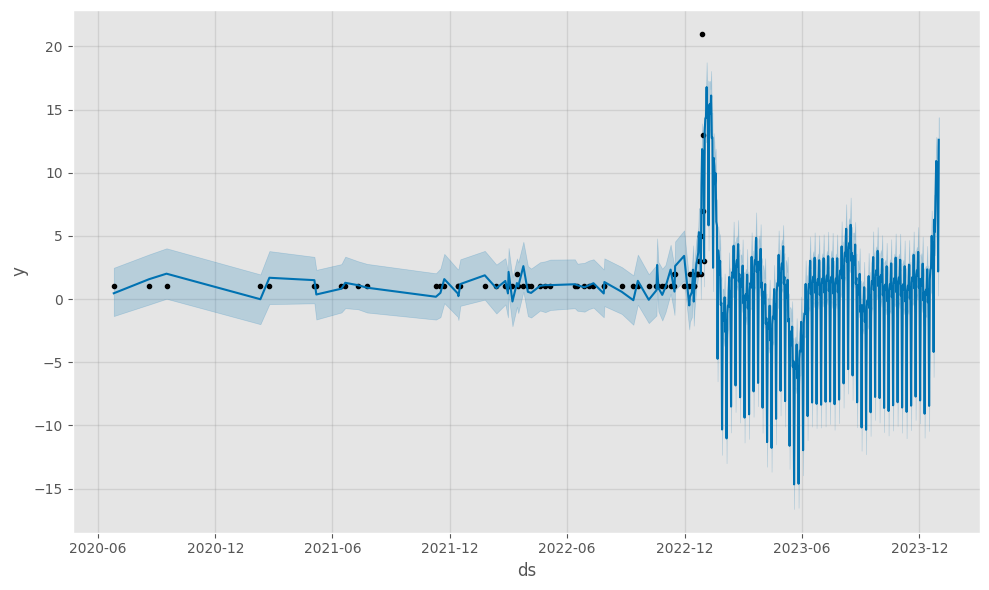

In [22]:
# Plot the forecast
model.plot(forecast);

In [23]:
# Evaluating Prophet

In [24]:
#To do this, we have to get the y-hat and original y's from the data
metric_df = pd.concat([forecast[['ds','yhat']],daily_requests_df['y']], axis=1)
metric_df.head()

,ds,yhat,y
0,2020-06-26,0.458564,1.0
1,2020-08-20,1.574292,1.0
2,2020-09-16,2.008798,1.0
3,2021-02-09,-0.013648,1.0
4,2021-02-23,1.686080,1.0


In [25]:
# check the tail, because we added 365 days of forecast.
metric_df.tail()

,ds,yhat,y
429,2023-12-27,10.927744,NaN
430,2023-12-28,9.107484,NaN
431,2023-12-29,10.805170,NaN
432,2023-12-30,2.184499,NaN
433,2023-12-31,12.606936,NaN


In [26]:
# The tail has NaN values, because they're predictions - there was no real Y. Let's drop those for model evaluation.
metric_df.dropna(inplace = True)

In [27]:
metric_df.tail()

,ds,yhat,y
64,2022-12-27,9.017592,5.0
65,2022-12-28,11.871441,21.0
66,2022-12-29,10.020825,7.0
67,2022-12-30,11.667913,13.0
68,2022-12-31,2.976653,3.0


In [28]:
metric_df.mean()

<ipython-input-28-7f1f133fff7e>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  metric_df.mean()


yhat    1.837327
y       1.840580
dtype: float64

In [29]:
#Let's take a look at the numbers - from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print("R-squared: ", r2_score(metric_df['y'], metric_df['yhat']))
print("Mean Squared Error: ", mean_squared_error(metric_df['y'], metric_df['yhat']))
print("RMSE: ", np.sqrt(mean_squared_error(metric_df['y'], metric_df['yhat'])))

R-squared:  0.7256801903953782
Mean Squared Error:  2.302880518856863
RMSE:  1.517524470595734


In [30]:
# Visualizing with holidays!

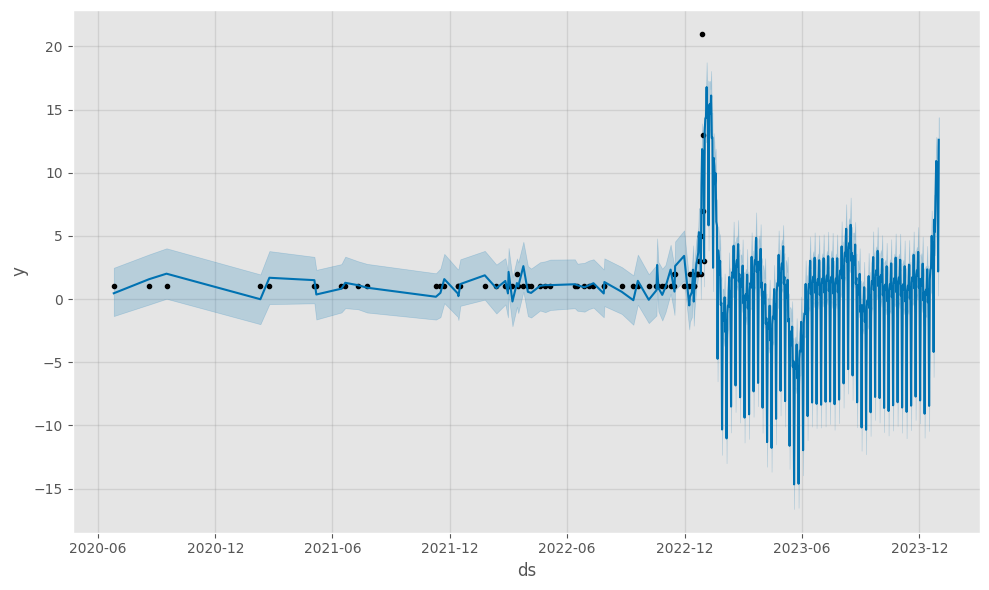

In [31]:
# use Prophet's .plot() method to visualize your timeseries.
model.plot(forecast);

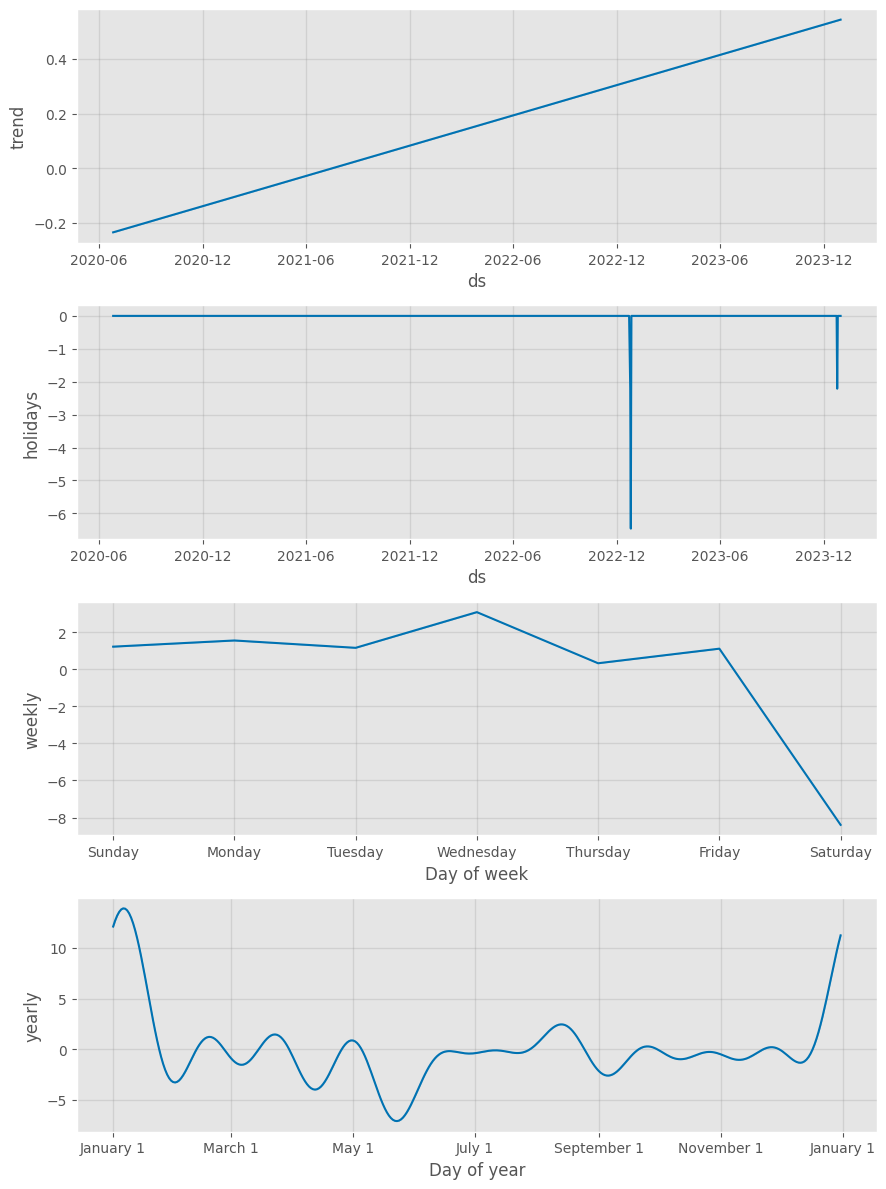

In [32]:
# View the components
model.plot_components(forecast);

R^2 0.7257 shows a reasonable model without overfitting.

Wednesday tends to have more service calls and winter months(December to Febuary) tend to have a heavy call amounts.